Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [16]:
from sklearn import datasets
X, y = datasets.load_digits(return_X_y=True)

In [17]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

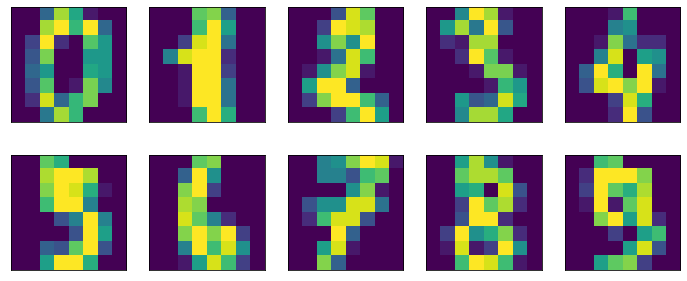

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def display_images(X, i, j, img_size=8):
    fig, axs =  plt.subplots(nrows=i, ncols=j, figsize=(12, 5), sharex='all', sharey='all')
    for ax, x in zip(axs.flatten(), X):
        img = np.reshape(x, (img_size, img_size))
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()    
    
display_images(X, 2, 5)

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [19]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [20]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=30
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
    
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        return np.linalg.norm(X[:, None, :] - cluster_centers[None, :, :], axis=-1)
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        df = pd.DataFrame(X)
        df = df.assign(cluster=nearest_clusters)
        return df.groupby("cluster").mean().to_numpy()
           
        
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        
        n_cluster_centers = []
        n_nearest_clusters = []
        for att in range(self.n_init):
            indices = self.random_state.choice(range(X.shape[0]), size=self.n_clusters, replace=False)
            cluster_centers = X[indices]
            for it in range(self.max_iter):
                dist = self.calculate_distances_to_centroids(X, cluster_centers)
                nearest_clusters_ind = np.argmin(dist, axis=1)
                cluster_centers = self.update_centroids(X, nearest_clusters_ind)
                nearest_clusters = cluster_centers[nearest_clusters_ind]
            n_cluster_centers.append(cluster_centers)
            n_nearest_clusters.append(nearest_clusters)
        L = []
        for nearest_clusters_ in n_nearest_clusters:
            L.append(np.sum(np.linalg.norm(X - nearest_clusters_, axis=1)**2))
        self.objective_ = np.min(L)
        self.cluster_centers_ = n_cluster_centers[np.argmin(L)]
        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            dist = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            return np.argmin(dist, axis=1)
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [21]:
cust_KMeans = CustomKMeans(n_clusters=10)
cust_KMeans.fit(X)
custom_kmeans_labels = cust_KMeans.predict(X)
assert custom_kmeans_labels.shape == (1797,)

Model centroids on the initial data


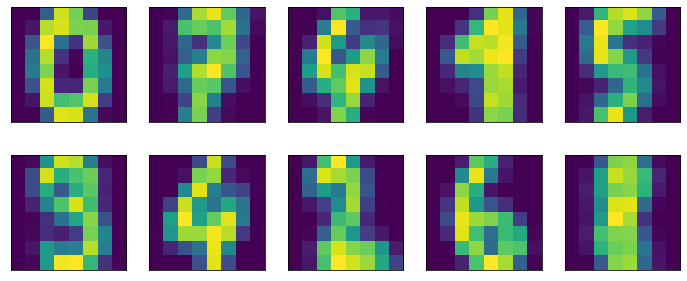

In [22]:
print("Model centroids on the initial data")
display_images(cust_KMeans.cluster_centers_, 2, 5)

Clusters centers on the initial data


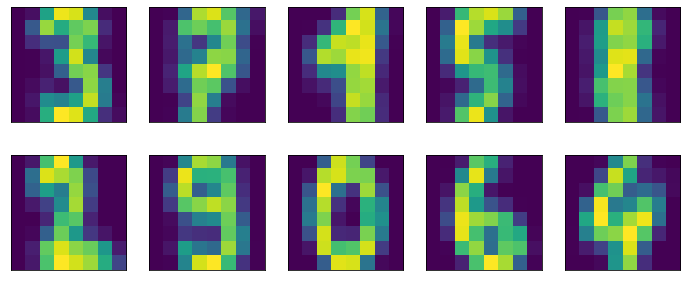

In [8]:
std_cluster_centers_ = cust_KMeans.update_centroids(X, cust_KMeans.predict(X))
print("Clusters centers on the initial data")
display_images(std_cluster_centers_, 2, 5)

Model centroids on the standartized data


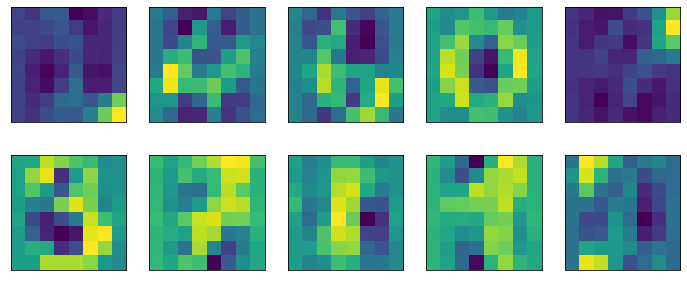

In [9]:
X_ = StandardScaler().fit_transform(X)
cust_KMeans = CustomKMeans(n_clusters=10)
cust_KMeans.fit(X_)
custom_kmeans_labels = cust_KMeans.predict(X_)
print("Model centroids on the standartized data")
display_images(cust_KMeans.cluster_centers_, 2, 5)

Cluster centers on the standartized data


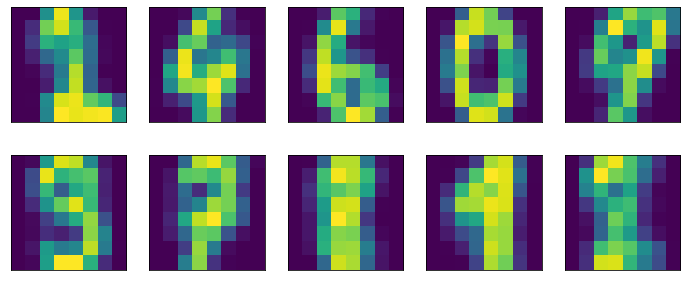

In [10]:
std_cluster_centers_ = cust_KMeans.update_centroids(X, cust_KMeans.predict(X_))
print("Cluster centers on the standartized data")
display_images(std_cluster_centers_, 2, 5)

Standartizing data doesn't influence significantly in case of this dataset, because features are in the same range initially. Model centroids for the standartized data are not satisfying, but calculated cluster centers are similar to ones for initial data.

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

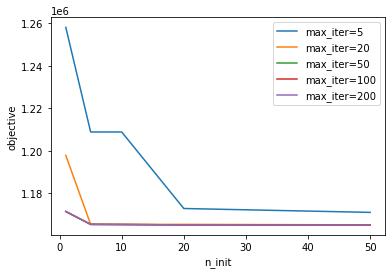

In [11]:
for max_iter in [5, 20, 50, 100, 200]:
    x_ax, y_ax = [], []
    y_ax_sk = []
    for n_init in [1, 5, 10, 20, 50]:
        cust_KMeans = CustomKMeans(n_clusters=10, max_iter=max_iter, n_init=n_init)
        cust_KMeans.fit(X)
        x_ax.append(n_init)
        y_ax.append(cust_KMeans.objective_)
        
        
    plt.plot(x_ax, y_ax, label="max_iter="+str(max_iter))

plt.legend()
plt.xlabel("n_init")
plt.ylabel("objective")
plt.show()

**Inference**: best objective is achieved starting from n_init = 5 for max_iter >= 20 and saves its' value.

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [12]:
from sklearn.cluster import AgglomerativeClustering, KMeans

In [13]:
agg = AgglomerativeClustering(n_clusters=10)
agg.fit(X)
hierarchical_labels = agg.labels_
kmeans = KMeans(n_clusters=10)
kmeans_labels = kmeans.fit_predict(X)

In [14]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

Hierarchical clustering


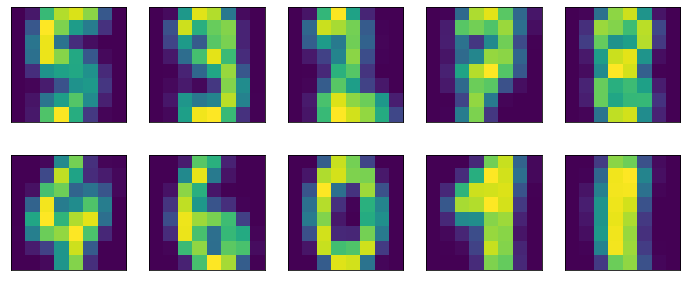

In [15]:
print("Hierarchical clustering")
agg_cluster_centers_ = cust_KMeans.update_centroids(X, agg.labels_)
display_images(agg_cluster_centers_, 2, 5)

K-Means


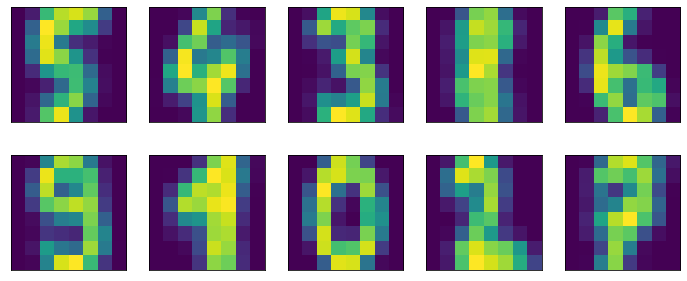

In [16]:
print("K-Means")
display_images(kmeans.cluster_centers_, 2, 5)

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

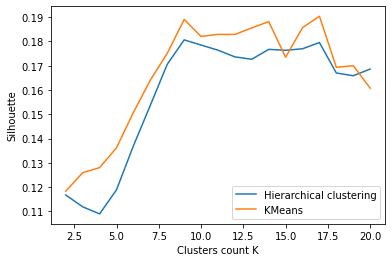

In [17]:
from sklearn.metrics import silhouette_score

K = range(2, 21)
agg_score, kmeans_score = [], []
for k in K:
    agg = AgglomerativeClustering(n_clusters=k)
    agg.fit(X)
    hierarchical_labels = agg.labels_
    agg_score.append(silhouette_score(X, hierarchical_labels, random_state=42))
    kmeans = KMeans(n_clusters=k)
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_score.append(silhouette_score(X, kmeans_labels, random_state=42))
    
plt.plot(K, agg_score, label="Hierarchical clustering")
plt.plot(K, kmeans_score, label="KMeans")
plt.xlabel("Clusters count K")
plt.ylabel("Silhouette")
plt.legend()
plt.show()

**Inference**: Silhouette metric has the best value for 9 clusters count and stays rather hight for bigger number of clusters. KMeans has a little bit greater silhouette.

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

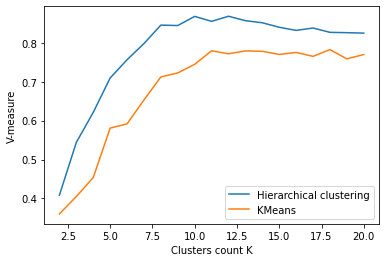

In [18]:
from sklearn.metrics import v_measure_score

K = range(2, 21)
agg_score, kmeans_score = [], []
for k in K:
    agg = AgglomerativeClustering(n_clusters=k)
    agg.fit(X)
    hierarchical_labels = agg.labels_
    agg_score.append(v_measure_score(y, hierarchical_labels))
    kmeans = KMeans(n_clusters=k)
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_score.append(v_measure_score(y, kmeans_labels))
    
plt.plot(K, agg_score, label="Hierarchical clustering")
plt.plot(K, kmeans_score, label="KMeans")
plt.xlabel("Clusters count K")
plt.ylabel("V-measure")
plt.legend()
plt.show()

**Inference**: V-measure has pick near 10 number of clusters and generally has the similar to siluette metric graph, but Hierarchical clustering has better results by this metric.

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

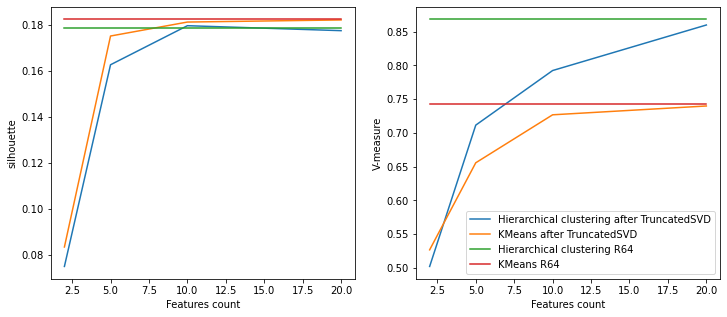

In [19]:
from sklearn.decomposition import TruncatedSVD

m = [2, 5, 10, 20]
agg_silhouette, kmeans_silhouette, agg_v_measure, kmeans_v_measure = [], [], [], []
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
X_c = X - np.mean(X, axis=0)
agg = AgglomerativeClustering(n_clusters=10)
kmeans = KMeans(n_clusters=10)
for k in m:
    svd = TruncatedSVD(n_components=k, random_state=42)
    X_ = svd.fit_transform(X_c)
    
    agg.fit(X_)
    hierarchical_labels = agg.labels_
    agg_silhouette.append(silhouette_score(X_c, hierarchical_labels, random_state=42))
    agg_v_measure.append(v_measure_score(y, hierarchical_labels))
    
    kmeans_labels = kmeans.fit_predict(X_)
    kmeans_silhouette.append(silhouette_score(X_c, kmeans_labels, random_state=42))
    kmeans_v_measure.append(v_measure_score(y, kmeans_labels))
    
ax[0].plot(m, agg_silhouette, label="Hierarchical clustering after TruncatedSVD")
ax[0].plot(m, kmeans_silhouette, label="KMeans after TruncatedSVD")
ax[0].set_xlabel("Features count")
ax[0].set_ylabel("silhouette")

ax[1].plot(m, agg_v_measure, label="Hierarchical clustering after TruncatedSVD")
ax[1].plot(m, kmeans_v_measure, label="KMeans after TruncatedSVD")
ax[1].set_xlabel("Features count")
ax[1].set_ylabel("V-measure")

agg.fit(X_c)
hierarchical_labels = agg.labels_
silhuette = np.full(4, silhouette_score(X_c, hierarchical_labels, random_state=42))
v_measure = np.full(4, v_measure_score(y, hierarchical_labels))
ax[0].plot(m, silhuette, label="Hierarchical clustering R64")
ax[1].plot(m, v_measure, label="Hierarchical clustering R64")
    
kmeans_labels = kmeans.fit_predict(X_c)
silhuette = np.full(4, silhouette_score(X_c, kmeans_labels, random_state=42))
v_measure = np.full(4, v_measure_score(y, kmeans_labels))
ax[0].plot(m, silhuette, label="KMeans R64")
ax[1].plot(m, v_measure, label="KMeans R64")
    
plt.legend()
plt.show()

**Inference**: silhouette and V-measure after applying dimensionality reduction grow and converge to the values of these metrics on initial data with number of components (features) growing.

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

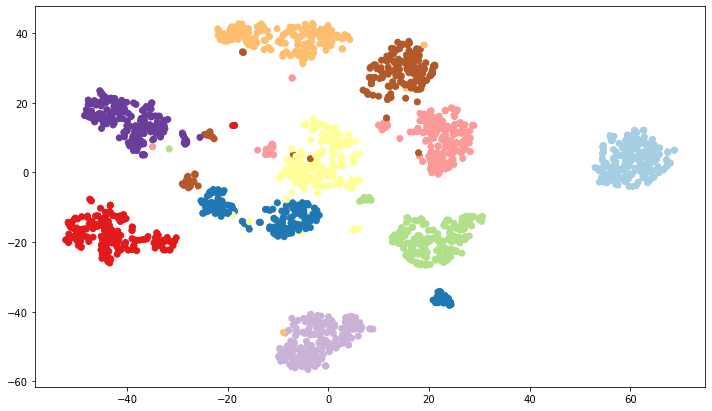

In [20]:
from sklearn.manifold import TSNE

X_emb = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42).fit_transform(X)
plt.figure(figsize=(12, 7))
plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y, cmap="Paired")
plt.show();

**Inference**: tSNE-transform saved distance between samples rather good and clusters can be visualized, but some samples have been positioned incorrectly after the transformation.

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [21]:
agg = AgglomerativeClustering(n_clusters=10)
agg.fit(X)
hierarchical_labels = agg.labels_
agg_silhuette = silhouette_score(X, hierarchical_labels, random_state=42)
agg_v_measure = v_measure_score(y, hierarchical_labels)

agg.fit(X_emb)
hierarchical_labels = agg.labels_
agg_silhuette_emb = silhouette_score(X, hierarchical_labels, random_state=42)
agg_v_measure_emb = v_measure_score(y, hierarchical_labels)


kmeans = KMeans(n_clusters=10)
kmeans_labels = kmeans.fit_predict(X)
kmeans_silhuette = silhouette_score(X, kmeans_labels, random_state=42)
kmeans_v_measure = v_measure_score(y, kmeans_labels)

kmeans_labels = kmeans.fit_predict(X_emb)
kmeans_silhuette_emb = silhouette_score(X, kmeans_labels, random_state=42)
kmeans_v_measure_emb = v_measure_score(y, kmeans_labels)



In [22]:
df = pd.DataFrame({"Type": ["original", "original", "embedded", "embedded"],
                   "Clustering": ["Hierarchical", "K-Means", "Hierarchical", "K-Means"],
                   "Silhouette": [agg_silhuette, kmeans_silhuette, agg_silhuette_emb, kmeans_silhuette_emb],
                   "V-measure": [agg_v_measure, kmeans_v_measure, agg_v_measure_emb, kmeans_v_measure_emb]
             })
df = df.set_index(["Type", "Clustering"])
df

Silhouette  V-measure
Type     Clustering                         
original Hierarchical    0.178497   0.868170
         K-Means         0.182479   0.743838
embedded Hierarchical    0.163059   0.898381
         K-Means         0.163595   0.904796

**Inference**: Silhouette on the embedded data became a little bit worse, but V-measure increased especially for K-Means.

**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

We've got the best V-measure for K-Means on embedded by tSNE data. So let's test this partition:

K-Means on tSNE transformed data


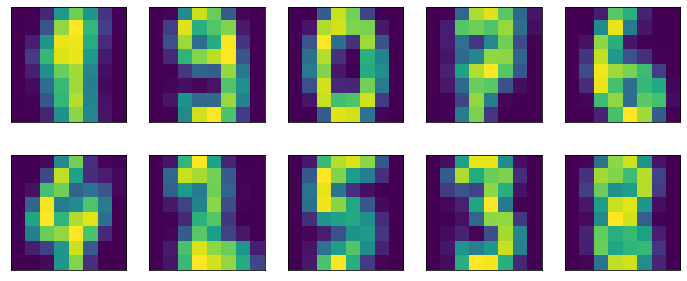

silhouette =  0.16359521333051144
V-measure 0.9047962874037275


In [23]:
print("K-Means on tSNE transformed data")
X_emb = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42).fit_transform(X)
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_emb)
cluster_centers_ = cust_KMeans.update_centroids(X, kmeans_labels)
display_images(cluster_centers_, 2, 5)
print("silhouette = ", silhouette_score(X, kmeans_labels, random_state=42))
print("V-measure", v_measure_score(y, kmeans_labels))

**Inference**: TSNE helps KMeans to achieve the best result and get pretty good pictures for all digits. Each digit corresponds to one cluster.

Hierarchical clutering on SVD transformed data


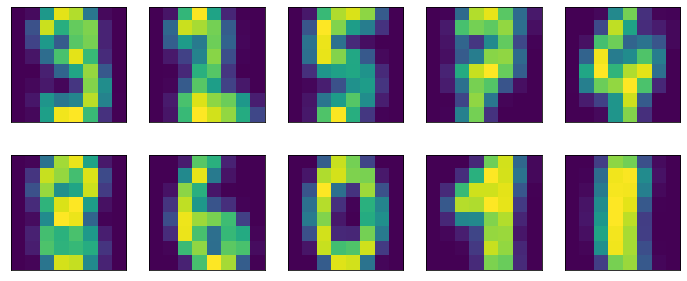

silhouette =  0.1775484116210011
V-measure 0.8598146766681029


In [24]:
print("Hierarchical clutering on SVD transformed data")
X_c = X - np.mean(X, axis=0)
svd = TruncatedSVD(n_components=20, random_state=42)
X_emb = svd.fit_transform(X_c)
agg = AgglomerativeClustering(n_clusters=10)
agg_labels = agg.fit_predict(X_emb)
cluster_centers_ = cust_KMeans.update_centroids(X, agg_labels)
display_images(cluster_centers_, 2, 5)
print("silhouette = ", silhouette_score(X, agg_labels, random_state=42))
print("V-measure", v_measure_score(y, agg_labels))

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

**Answer:** For our initial dataset hierarchical clustering has noticeably higher V-measure and a little bit smaller silhouette than 𝐾-means and this difference saves for different clusters count with other default algorithm settings. Images of cluster centers have almost the same quality. The same situation with silhouette and v-measure is on data after SVD transformation. Only after tSME tranformation K-Means achieves higher V-measure than hierarchical clustering and it gives the best images of cluster centroids.

In general:
* hierarchical clustering gives more meaningful results if we don't know the number of clusters. 
* K-Means clustering works well on clusters that have symmetric forms(shperical-shape) and gives worse results on data with outliers. For K-Means we should know number of clusters or try for different number and choose it with elbow method.
* DBSCAN can deal with clusters that have arbitraty form, nested clusters and data with outliers.

If we know target labels we can use V-measure for clustering **quality evaluation**. Otherwise we can use silhouette score. For K-means tuning we can also asses objective.

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

**Answer**: 
1. Calculate the centroids of each found cluster, then for each sample in new data find the nearest centroid and mark the sample with this cluster label. For measuring I will calculate silhuoette score. If I have a big new data I will calculate silhuoette score for it separetely, but if it's small, this quality evaluation method can be uninformative. In any case it worth to concatenate train data with new data and the same for cluster labels and calculate the silhouette score for them. It shouldn't change significantly.
2. Consider cluster labels as classes and use KNN to classificate new data. Use accuracy for quality evaluation.

**(0.5 points)** Does dimensionality reduction improve clustering results?

**Answer**: Dimensionality reduction can either improve or worsen clustering results. If data has noise, removing this noisy features will increase clustering results. Also if there are collinear features then dimensionality reduction will increase clustering results too. If all features are important and independent than dimensionality reduction will worsen clustering results. Also it depends on number of features to leave and method of reduction. Tuning this parameter and testing different methods allows to choose one to achieve better clustering results in most case.

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

* check that dimensionality reduction saves pairwise dissimilarities (pairwise distance between samples, neighborhood probabilities, ranks of the neighbors) using stress function or scatter plots of pairwise distances (except of for themselves) of original data on x-axes and scaled data on y-axes (in the best case we should see a straight line).
* check that dimensionality reduction saves data variance 
* compare silhouette and, if possible, V-measure of clustering on initial and reducted data

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [7]:
from sklearn.datasets import fetch_openml
X_mn, y_mn = fetch_openml('mnist_784', version=1, return_X_y=True)

In [8]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.7)
X_mn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 418.7 MB


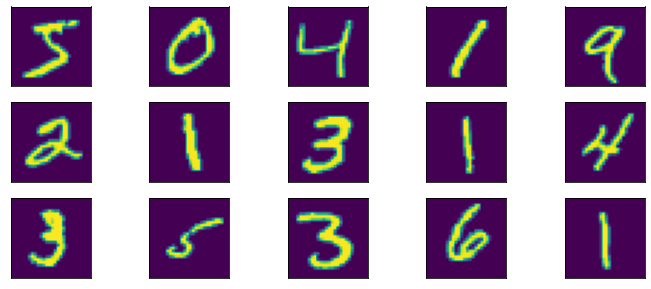

In [8]:
X_mn = X_mn.to_numpy()
display_images(X_mn, 3, 5, 28) 

In [28]:
y_mn.value_counts()

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: class, dtype: int64

There are all 10 digits in dataset and same digits often save different slope - placed in different pixels.

In [15]:
y_mn = y_mn.to_numpy()
cust_KMeans = CustomKMeans(n_clusters=10)

Hierarchical clustering


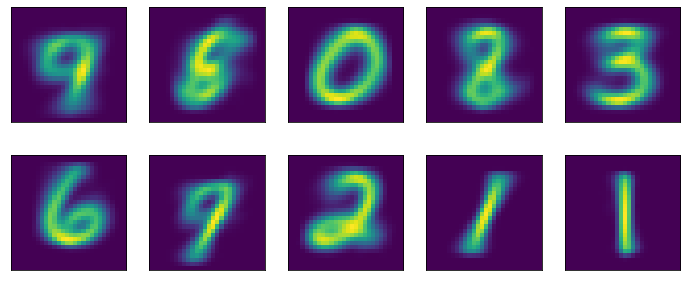

In [30]:
print("Hierarchical clustering")
agg = AgglomerativeClustering(n_clusters=10)
# Hierarchical clustering unable to allocate memory for such a big database, so let's take first 20000
agg.fit(X_mn[:20000, :])
hierarchical_labels = agg.labels_
agg_cluster_centers_ = cust_KMeans.update_centroids(X_mn[:20000, :], agg.labels_)
display_images(agg_cluster_centers_, 2, 5, 28)

K-Means


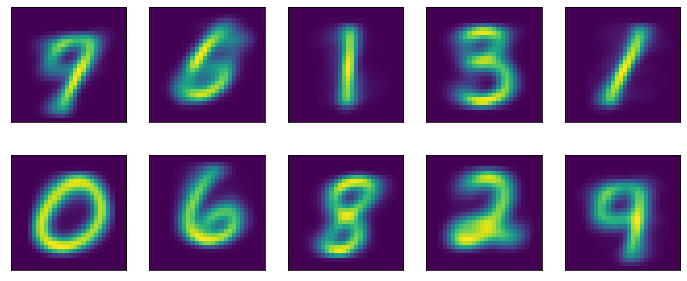

In [31]:
kmeans = KMeans(n_clusters=10)
kmeans_labels = kmeans.fit_predict(X_mn)
print("K-Means")
display_images(kmeans.cluster_centers_, 2, 5, 28)

In [9]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score

In [32]:
X_mn_sh = X_mn[:20000, :]
y_mn_sh = y_mn[:20000]
agg_silhuette = silhouette_score(X_mn_sh, hierarchical_labels, random_state=42)
agg_v_measure = v_measure_score(y_mn_sh, hierarchical_labels)

kmeans_silhuette = silhouette_score(X_mn, kmeans_labels, random_state=42)
kmeans_v_measure = v_measure_score(y_mn, kmeans_labels)

df = pd.DataFrame({
                   "Clustering": ["Hierarchical", "K-Means"],
                   "Silhouette": [agg_silhuette, kmeans_silhuette],
                   "V-measure": [agg_v_measure, kmeans_v_measure]
             })
df = df.set_index(["Clustering"])
df

,Silhouette,V-measure
Clustering,,
Hierarchical,0.020213,0.635856
K-Means,0.058692,0.499744


Hierarchical clustering and K-means doesn't clusterizing well on the initial data - they put some same digits in different clusters and their silhouette score is very small, V-measure is middle.

In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

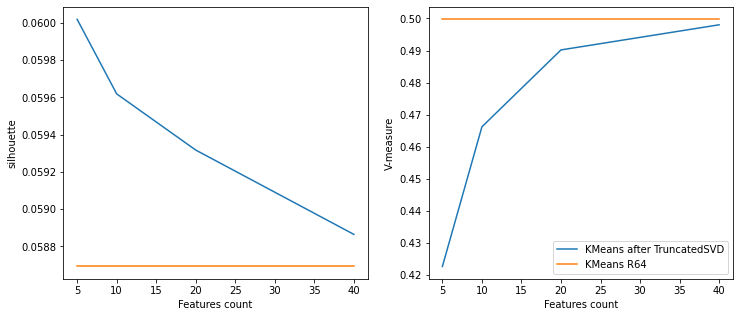

In [33]:
m = [5, 10, 20, 40]
kmeans_silhouette, kmeans_v_measures = [], []
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
X_c = X_mn - np.mean(X_mn, axis=0)
kmeans = KMeans(n_clusters=10)
for k in m:
    svd = TruncatedSVD(n_components=k, random_state=42)
    X_ = svd.fit_transform(X_c)
    
    kmeans_labels = kmeans.fit_predict(X_)
    kmeans_silhouette.append(silhouette_score(X_c, kmeans_labels, random_state=42))
    kmeans_v_measures.append(v_measure_score(y_mn, kmeans_labels))

ax[0].plot(m, kmeans_silhouette, label="KMeans after TruncatedSVD")
ax[0].set_xlabel("Features count")
ax[0].set_ylabel("silhouette")

ax[1].plot(m, kmeans_v_measures, label="KMeans after TruncatedSVD")
ax[1].set_xlabel("Features count")
ax[1].set_ylabel("V-measure")

kmeans_labels = kmeans.fit_predict(X_c)
silhuette = np.full(4, silhouette_score(X_c, kmeans_labels, random_state=42))
v_measure = np.full(4, v_measure_score(y_mn, kmeans_labels))
ax[0].plot(m, silhuette, label="KMeans R64")
ax[1].plot(m, v_measure, label="KMeans R64")
    
plt.legend()
plt.show()

In [34]:
svd = TruncatedSVD(n_components=20, random_state=42)
X_ = svd.fit_transform(X_c)
    
kmeans_labels = kmeans.fit_predict(X_)
kmeans_silhuette_svd = silhouette_score(X_c, kmeans_labels, random_state=42)
kmeans_v_measure_svd = v_measure_score(y_mn, kmeans_labels)


In [35]:
svd = TruncatedSVD(n_components=20, random_state=42)
X_sh = X_mn[:30000, :]
X_c = X_sh - np.mean(X_sh, axis=0)
X_ = svd.fit_transform(X_c)
    
agg.fit(X_)
hierarchical_labels = agg.labels_
agg_silhuette_svd = silhouette_score(X_sh, hierarchical_labels, random_state=42)
agg_v_measure_svd = v_measure_score(y_mn[:30000], hierarchical_labels)


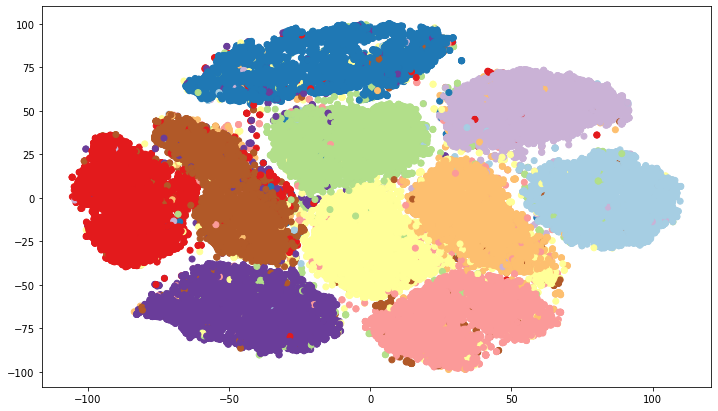

In [36]:
X_emb = TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=-1, random_state=42).fit_transform(X_mn)
kmeans_labels = kmeans.fit_predict(X_emb)
kmeans_silhouette_tsne2 = silhouette_score(X_mn, kmeans_labels, random_state=42)
kmeans_v_measure_tsne2 = v_measure_score(y_mn, kmeans_labels)

agg.fit(X_emb[:30000, :])
hierarchical_labels = agg.labels_
agg_silhuette_tsne2 = silhouette_score(X_sh, hierarchical_labels, random_state=42)
agg_v_measure_tsne2 = v_measure_score(y_mn[:30000], hierarchical_labels)

plt.figure(figsize=(12, 7))
plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y_mn.astype(int), cmap="Paired")
plt.show();

tSNE for 2 components does well - badly clustered samples number is low.

In [37]:
X_emb = TSNE(n_components=3, learning_rate='auto', init='random', n_jobs=-1, random_state=42).fit_transform(X_mn)
kmeans_labels = kmeans.fit_predict(X_emb)
kmeans_silhouette_tsne3 = silhouette_score(X_mn, kmeans_labels, random_state=42)
kmeans_measure_tsne3 = v_measure_score(y_mn, kmeans_labels)

agg.fit(X_emb[:30000, :])
hierarchical_labels = agg.labels_
agg_silhuette_tsne3 = silhouette_score(X_sh, hierarchical_labels, random_state=42)
agg_v_measure_tsne3 = v_measure_score(y_mn[:30000], hierarchical_labels)

In [38]:
df = pd.DataFrame({"Type": ["original", "original", "SVD", "SVD", "tSNE 2D", "tSNE 2D", "tSNE 3D", "tSNE 3D"
                           ],
                   "Clustering": ["K-Means", "Hierarchical", "K-Means", "Hierarchical", "K-Means", "Hierarchical", 
                                  "K-Means", "Hierarchical"],
                   "Silhouette": [kmeans_silhuette, agg_silhuette, kmeans_silhuette_svd, agg_silhuette_svd,
                                  kmeans_silhouette_tsne2, agg_silhuette_tsne2, 
                                  kmeans_silhouette_tsne3, agg_silhuette_tsne3],
                   "V-measure": [kmeans_v_measure, agg_v_measure, kmeans_v_measure_svd, agg_v_measure_svd,
                                 kmeans_v_measure_tsne2, agg_v_measure_tsne2, 
                                 kmeans_measure_tsne3, agg_v_measure_tsne3]
             })
df = df.set_index(["Type", "Clustering"])
df

Silhouette  V-measure
Type     Clustering                         
original K-Means         0.058692   0.499744
         Hierarchical    0.020213   0.635856
SVD      K-Means         0.059240   0.490699
         Hierarchical    0.027000   0.686813
tSNE 2D  K-Means         0.034554   0.805821
         Hierarchical    0.049683   0.861584
tSNE 3D  K-Means         0.042606   0.810265
         Hierarchical    0.044971   0.893829

I wanted to test MDS and PCA too, but my computer couldn't manage them even for slice of data.


Clustering after tSNE achieves really good V-measure. For tSNE with 3 components V-measure is higher. Let's try K-Means and hierarchical clustering after tSNE for 3 components.

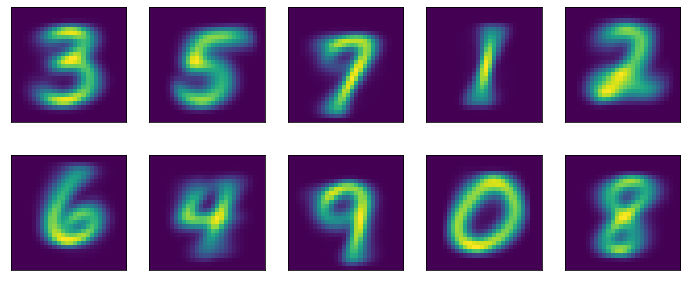

In [43]:
X_emb = TSNE(n_components=3, learning_rate='auto', init='random', n_jobs=-1, random_state=42).fit_transform(X_mn)
kmeans_labels = kmeans.fit_predict(X_emb)
kmeans_silhouette_tsne3 = silhouette_score(X_mn, kmeans_labels, random_state=42)
kmeans_measure_tsne3 = v_measure_score(y_mn, kmeans_labels)
cluster_centers_ = cust_KMeans.update_centroids(X_mn, kmeans_labels)
display_images(cluster_centers_, 2, 5, 28)

In [42]:
print("Silhouette:", kmeans_silhouette_tsne3)
print("V-measure:", kmeans_measure_tsne3)

Silhouette: 0.04264677449373899
V-measure: 0.8097998754277622


K-means after tSNE with 3 components gives good results - each digit is recognized as a separate cluster, there are no duplicated digits. V-measure is rather high. Silhouette score is very low. I think it's due to small distance between clusters and relatively high distance between some samples in one cluster when the same digit has different writing (e.g. with different slope).

Unfortunately, I don't have resources to execute hierarchical clustering on the whole dataset.

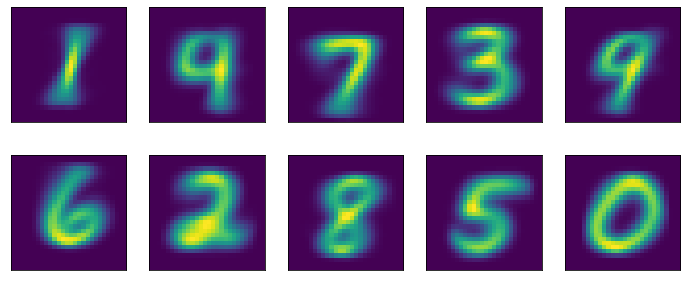

In [12]:
X_emb = TSNE(n_components=3, learning_rate='auto', init='random', n_jobs=-1, random_state=42).fit_transform(X_mn[:30000, :])
agg = AgglomerativeClustering(n_clusters=10)
agg_labels = agg.fit_predict(X_emb)
agg_silhuette_tsne3 = silhouette_score(X_mn[:30000, :], agg_labels, random_state=42)
agg_v_measure_tsne3 = v_measure_score(y_mn[:30000], agg_labels)
cust_KMeans = CustomKMeans(n_clusters=10)
cluster_centers_ = cust_KMeans.update_centroids(X_mn[:30000, :], agg_labels)
display_images(cluster_centers_, 2, 5, 28)

In [13]:
print("Silhouette:", agg_silhuette_tsne3)
print("V-measure:", agg_v_measure_tsne3)

Silhouette: 0.04966364131760739
V-measure: 0.8339687868039352


Hierarchical clustering on the shorten dataset of the first 30000 samples gave the same to K-Means results. V-measure is a little bit bigger.